# 2D Advection-Diffusion Equation

$$u_t = 0.25u_{x} + 0.5 u_{y} + 0.5u_{xx} + 0.5 u_{yy}$$ 


In [1]:
import os
import numpy as np
import pandas as pd 
import scipy.io as sio
import matplotlib.pyplot as plt
import torch
import tensorflow as tf

from torch.autograd import grad
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ExponentialLR

from pdefind import *
from Model_Identification.PDE_Equation import pde_matrix_mul, sparse_coeff, normalized_xi_threshold, pde_Recover
from Model_Identification.build_Library import construct_Dictonary_2D_Deriv3
from datetime import datetime

In [2]:
start_time = datetime.now()

# Prepare dataset
data = sio.loadmat(os.path.join(os.getcwd(), "../data", "Advection_diffusion.mat"))
usol = np.real(data['Expression1'])
print('u.shape', usol.shape)
usol= usol.reshape((51,51,61,4))
#u = data["usol"]
x = usol[:,:,:,0]
y = usol[:,:,:,1]
t = usol[:,:,:,2]
u = usol[:,:,:,3]
print('u.shape', u.shape)
print('x.shape', x.shape)
print('t.shape', t.shape)
print('y.shape', y.shape)
print(x[:,:,10].shape)


u.shape (634644, 1)
u.shape (51, 51, 61)
x.shape (51, 51, 61)
t.shape (51, 51, 61)
y.shape (51, 51, 61)
(51, 51)


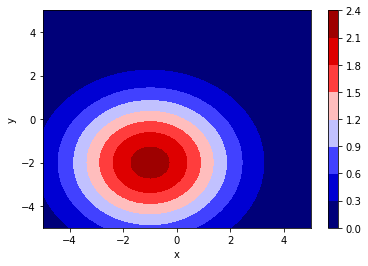

In [3]:
fig, ax = plt.subplots()

im = ax.contourf(x[:,:,10], y[:,:,10], u[:,:,10], cmap='seismic')
ax.set_xlabel('x')
ax.set_ylabel('y')

fig.colorbar(mappable=im)

plt.show()

In [4]:
X = np.transpose((t.flatten(),x.flatten(), y.flatten()))
Y = u.reshape((u.size, 1))
print(X.shape, Y.shape)
print('X:', X)

(158661, 3) (158661, 1)
X: [[ 3.  -5.  -5. ]
 [ 3.1 -5.  -5. ]
 [ 3.2 -5.  -5. ]
 ...
 [ 8.8  5.   5. ]
 [ 8.9  5.   5. ]
 [ 9.   5.   5. ]]


In [5]:
# Add noise
np.random.seed(0)
noise_level = 0.1
y = Y + noise_level * np.std(Y) * np.random.randn(Y.size, 1)



In [6]:
# Setup Network
net = PINN(sizes=[3,20,20,20,20,20,1], activation=torch.nn.Tanh())
print(net)

PINN(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Tanh()
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Tanh()
    (6): Linear(in_features=20, out_features=20, bias=True)
    (7): Tanh()
    (8): Linear(in_features=20, out_features=20, bias=True)
    (9): Tanh()
    (10): Linear(in_features=20, out_features=1, bias=True)
  )
)


In [7]:
polynm = ['1', 'u', 'uˆ2', 'uˆ3']
#polynm = ['1', 'u', 'uˆ2']
#spa_der = ['1', 'u_{x}', 'u_{y}','u_{xx}', 'u_{yy}','u_{xy}']
spa_der = ['1', 'u_{x}', 'u_{y}','u_{xx}', 'u_{yy}','u_{xy}','u_{xxx}','u_{xxy}','u_{xyy}','u_{yyy}']
library_coeffs = pde_matrix_mul(polynm, spa_der)
print('library_coeffs:', library_coeffs)

tot_items = len(library_coeffs)
print('tot_items:', tot_items)

mask = torch.ones(tot_items, 1)
epochs = 10000
xi = nn.Parameter(torch.randn((tot_items, 1), requires_grad=True, device="cpu", dtype=torch.float32))
#params = [{'params': net.parameters(), 'lr': 3e-3}, {'params': xi, 'lr': 3e-2}]
params = [{'params': net.parameters(), 'lr': 1e-3}, {'params': xi, 'lr': 1e-2}]

optimizer = Adam(params)
scheduler = ExponentialLR(optimizer, .9998)

library_coeffs: ['1', 'u_{x}', 'u_{y}', 'u_{xx}', 'u_{yy}', 'u_{xy}', 'u_{xxx}', 'u_{xxy}', 'u_{xyy}', 'u_{yyy}', 'u', 'uu_{x}', 'uu_{y}', 'uu_{xx}', 'uu_{yy}', 'uu_{xy}', 'uu_{xxx}', 'uu_{xxy}', 'uu_{xyy}', 'uu_{yyy}', 'uˆ2', 'uˆ2u_{x}', 'uˆ2u_{y}', 'uˆ2u_{xx}', 'uˆ2u_{yy}', 'uˆ2u_{xy}', 'uˆ2u_{xxx}', 'uˆ2u_{xxy}', 'uˆ2u_{xyy}', 'uˆ2u_{yyy}', 'uˆ3', 'uˆ3u_{x}', 'uˆ3u_{y}', 'uˆ3u_{xx}', 'uˆ3u_{yy}', 'uˆ3u_{xy}', 'uˆ3u_{xxx}', 'uˆ3u_{xxy}', 'uˆ3u_{xyy}', 'uˆ3u_{yyy}']
tot_items: 40


In [8]:
def model_identification(features, label, mask, poly_order, deriv_order):
    
    xi1 = []
    xi2 = []
    xi3 = []
    xi4 = []
    xi1_error_app = []
    xi2_error_app = []
    xi3_error_app = []
    xi4_error_app = []
    xi_update_app = []
    
    numbers = [0, 5, 26, 57, 73, 80, 95, 104, 129, 151]
    

    correct_prediction = 0
    # Using for loop
    for i in numbers:
        np.random.seed(i)
        print('seed:', i)
        idxs = np.random.choice(y.size, 2000, replace=False)
        X_train = torch.tensor(features[idxs], dtype=torch.float32, requires_grad=True)
        y_train = torch.tensor(label[idxs], dtype=torch.float32)
    
        lamb   = 0
        tolerance = 1e-6
        mask = torch.ones(tot_items, 1)
        #print('xi', xi)
        print('mask:', mask.shape)
        lambd  = 1e-6
    
        for epoch in range(epochs):
            optimizer.zero_grad()
            uhat = net(X_train)
    
            if epoch == 1000:
                lamb = 1
               
            dudt, theta = construct_Dictonary_2D_Deriv3(X_train, uhat, poly_order=3, deriv_order=3)
            #print('dudt:', dudt.shape)
            dudt_norm = torch.norm(dudt, dim=0)
    
            theta_scaling = (torch.norm(theta, dim=0))
            #Returns a new tensor with a dimension of size one inserted at the specified position. from 9 it will be 9,1
            theta_norm = torch.unsqueeze(theta_scaling, dim = 1) 
            xi_normalized = xi * (theta_norm / dudt_norm) 
            L1 = lambd * torch.sum(torch.abs(xi_normalized[1:, :]))
        
            l_u   = nn.MSELoss()(uhat, y_train)
            l_reg = lamb * torch.mean((dudt - theta @ xi)**2)
            #l_reg = torch.mean((dudt - theta @ xi)**2)

            loss = l_u + l_reg + L1

            gradient_loss = torch.max(torch.abs(grad(outputs=loss, inputs=xi, 
                  grad_outputs=torch.ones_like(loss), create_graph=True)[0]) / (theta_norm / dudt_norm))


            loss.backward(retain_graph=True)
            optimizer.step()
        
            if epoch % 1000 == 0:
                print('loss:', epoch, loss)
                if gradient_loss < tolerance:
                    print('Optimizer converged.')
                    break
 
        xi_list = sparse_coeff(mask, xi.detach().numpy())
        xi_normalized = sparse_coeff(mask, xi_normalized.detach().numpy())
        print('xi_normalized:', xi_normalized)
    

        sparsity = normalized_xi_threshold( xi_normalized, mode='auto')
        print('sparsity:', sparsity)
    
        xi_thresholded = np.expand_dims(xi_list[sparsity], axis=1) 
        print('xi_thresholded:', xi_thresholded)
        
        print('Coefficient xi:')
        xi_update = sparse_coeff(sparsity, xi_thresholded)
        print('xi_update:', xi_update)
        
    
        # Calculate Error in xi    
        if xi_update[1] != 0 and xi_update[2] != 0 and xi_update[3] != 0 and xi_update[4] != 0 and len(xi_thresholded) < 5:
            xi_update_app.append(xi_update)
            #print('xi_update_app:', xi_update_app)
            print('xi_update:', xi_update[1], xi_update[2], xi_update[3], xi_update[4])
            error_1 = np.subtract(np.array([0.25000]),xi_update[1])
            xi1_error = np.append(xi1, error_1)
            print('xi1_error', xi1_error)
            error_2 = np.subtract(np.array([0.50000]),xi_update[2])
            xi2_error = np.append(xi2, error_2)
            print('xi2_error', xi2_error)
            error_3 = np.subtract(np.array([0.50000]),xi_update[3])
            xi3_error = np.append(xi3, error_3)
            print('xi3_error', xi3_error)
            error_4 = np.subtract(np.array([0.50000]),xi_update[4])
            xi4_error = np.append(xi4, error_4)
            print('xi4_error', xi4_error)
            xi1_error_app.append(xi1_error)
            print('xi1_error_app:', xi1_error_app)
            xi2_error_app.append(xi2_error)
            print('xi2_error_app:', xi2_error_app)
            xi3_error_app.append(xi3_error)
            print('xi3_error_app:', xi3_error_app)
            xi4_error_app.append(xi4_error)
            print('xi4_error_app:', xi4_error_app)
            correct_prediction += 1
            
        else:
            print('PDE prediction not correct')
            
            
    print('correct_prediction:', correct_prediction)
    Accuracy = correct_prediction / len(numbers) * 100
    print('Accuracy:', Accuracy)
    xi1_error_avg = np.sum(xi1_error_app, axis = 0) / correct_prediction  
    print('xi1_error_avg:', xi1_error_avg)
    xi2_error_avg = np.sum(xi2_error_app, axis = 0) / correct_prediction 
    print('xi2_error_avg:', xi2_error_avg)
    xi3_error_avg = np.sum(xi3_error_app, axis = 0) / correct_prediction  
    print('xi3_error_avg:', xi3_error_avg)
    xi4_error_avg = np.sum(xi4_error_app, axis = 0) / correct_prediction 
    print('xi4_error_avg:', xi4_error_avg)
    xi_updated = np.sum(xi_update_app, axis = 0) / correct_prediction  
    print('xi_updated:', xi_updated)
    print('Finished')
    return xi_updated

In [9]:
xi_updated = model_identification(X, y, mask, poly_order=3, deriv_order=3)

seed: 0
mask: torch.Size([40, 1])
loss: 0 tensor(0.3622, grad_fn=<AddBackward0>)
loss: 1000 tensor(0.1864, grad_fn=<AddBackward0>)
loss: 2000 tensor(0.0027, grad_fn=<AddBackward0>)
loss: 3000 tensor(0.0025, grad_fn=<AddBackward0>)
loss: 4000 tensor(0.0025, grad_fn=<AddBackward0>)
loss: 5000 tensor(0.0024, grad_fn=<AddBackward0>)
loss: 6000 tensor(0.0024, grad_fn=<AddBackward0>)
loss: 7000 tensor(0.0024, grad_fn=<AddBackward0>)
loss: 8000 tensor(0.0024, grad_fn=<AddBackward0>)
loss: 9000 tensor(0.0024, grad_fn=<AddBackward0>)
xi_normalized: [[ 1.65310539e-02]
 [ 3.78297478e-01]
 [ 6.90378964e-01]
 [ 3.33181441e-01]
 [ 2.70887703e-01]
 [ 4.60640620e-03]
 [ 2.74800342e-02]
 [ 5.87143451e-02]
 [ 1.61277819e-02]
 [ 3.57942320e-02]
 [ 2.98944831e-01]
 [ 9.47032794e-02]
 [ 2.14371681e-01]
 [-9.22500417e-02]
 [ 6.55621523e-03]
 [-3.27548594e-03]
 [-7.33045815e-03]
 [-5.05393222e-02]
 [-1.16922677e-01]
 [ 2.34892468e-05]
 [-8.80978048e-01]
 [-3.02603424e-01]
 [-3.97918642e-01]
 [ 9.88235176e-02

loss: 1000 tensor(0.0039, grad_fn=<AddBackward0>)
loss: 2000 tensor(0.0023, grad_fn=<AddBackward0>)
loss: 3000 tensor(0.0023, grad_fn=<AddBackward0>)
loss: 4000 tensor(0.0023, grad_fn=<AddBackward0>)
loss: 5000 tensor(0.0023, grad_fn=<AddBackward0>)
loss: 6000 tensor(0.0023, grad_fn=<AddBackward0>)
loss: 7000 tensor(0.0025, grad_fn=<AddBackward0>)
loss: 8000 tensor(0.0023, grad_fn=<AddBackward0>)
loss: 9000 tensor(0.0023, grad_fn=<AddBackward0>)
xi_normalized: [[-2.29949434e-03]
 [ 3.93455267e-01]
 [ 4.60307807e-01]
 [ 5.18845201e-01]
 [ 2.66676962e-01]
 [-8.59624594e-02]
 [ 1.01781063e-01]
 [ 3.49378921e-02]
 [-4.51261923e-02]
 [-5.02075627e-02]
 [ 2.03206353e-02]
 [ 7.33786002e-02]
 [ 3.87609273e-01]
 [-3.03271919e-01]
 [ 2.31826445e-03]
 [ 2.25036815e-01]
 [ 8.91852309e-04]
 [-4.45912266e-03]
 [ 1.00940205e-01]
 [ 1.48818195e-01]
 [-5.47536823e-04]
 [-2.59087537e-03]
 [-6.30312115e-02]
 [ 3.64395510e-03]
 [ 1.94399625e-01]
 [-2.24590272e-01]
 [-8.83917511e-02]
 [ 3.96984717e-04]
 [-

loss: 1000 tensor(0.0038, grad_fn=<AddBackward0>)
loss: 2000 tensor(0.0024, grad_fn=<AddBackward0>)
loss: 3000 tensor(0.0024, grad_fn=<AddBackward0>)
loss: 4000 tensor(0.0023, grad_fn=<AddBackward0>)
loss: 5000 tensor(0.0023, grad_fn=<AddBackward0>)
loss: 6000 tensor(0.0023, grad_fn=<AddBackward0>)
loss: 7000 tensor(0.0024, grad_fn=<AddBackward0>)
loss: 8000 tensor(0.0023, grad_fn=<AddBackward0>)
loss: 9000 tensor(0.0023, grad_fn=<AddBackward0>)
xi_normalized: [[ 5.01777492e-02]
 [ 1.96751654e-01]
 [ 5.59693754e-01]
 [ 2.66764134e-01]
 [ 1.85915351e-01]
 [-1.04791131e-02]
 [ 1.70726576e-04]
 [ 4.20514308e-02]
 [ 1.92930866e-02]
 [ 3.86414379e-02]
 [ 6.81231096e-02]
 [ 3.35469544e-01]
 [ 4.66713548e-01]
 [ 1.00008421e-01]
 [ 2.96870887e-01]
 [ 7.23483099e-05]
 [ 1.83075215e-04]
 [ 4.44785319e-02]
 [-2.13613696e-02]
 [-1.94529265e-01]
 [-3.45090300e-01]
 [-1.65821508e-01]
 [-5.68323076e-01]
 [-8.79353061e-02]
 [-4.14487034e-01]
 [ 7.50806974e-03]
 [ 1.85246885e-01]
 [-1.22381243e-04]
 [ 

c:\users\happy\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:118: RuntimeWarning: invalid value encountered in double_scalars
c:\users\happy\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:120: RuntimeWarning: invalid value encountered in double_scalars
c:\users\happy\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:122: RuntimeWarning: invalid value encountered in double_scalars
c:\users\happy\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in double_scalars
c:\users\happy\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in double_scalars


In [10]:
pde_Recover(xi_updated, library_coeffs, equation_form='u_t')
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

IndexError: invalid index to scalar variable.